In [22]:
beta_dict.shape

(251,)

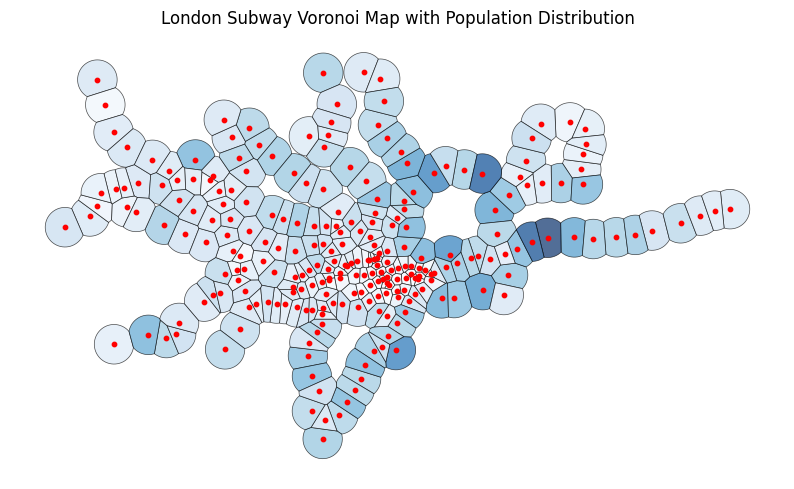

In [1]:
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from rasterstats import zonal_stats
import pickle

with open("London Station Borough List.pkl", "rb") as file:
    station_borough_list = pickle.load(file)
    
with open("London Station List.pkl", "rb") as file:
    station_list = pickle.load(file)
    
with open("best_home_betas.pkl", "rb") as file:
    beta_dict = pickle.load(file)
    
real_beta_dict = {}

for i in range(251):
    real_beta_dict[station_list[i]] = beta_dict[i]
    
beta_dict = real_beta_dict.copy()

with open("Updated Formalized London Beta.pkl", "rb") as file:
    best_beta_yet_0 = pickle.load(file)
    
for i in range(251):
    beta_dict[station_list[i]] = best_beta_yet_0[i]

# File paths
voronoi_shapefile = "London_Voronoi_File_1_5km.shp"  # Your Voronoi regions
population_raster = "population_gbr_2019-07-01.tif"  # Your population raster file

# Load Voronoi regions
voronoi_gdf = gpd.read_file(voronoi_shapefile)

# Ensure CRS matches raster file
with rasterio.open(population_raster) as src:
    raster_crs = src.crs
    voronoi_gdf = voronoi_gdf.to_crs(raster_crs)

# Compute zonal statistics (sum of population within each Voronoi slice)
stats = zonal_stats(voronoi_gdf, population_raster, stats=["sum"], nodata=np.nan)

# Assign population data and handle NaN values
voronoi_gdf["population"] = [s["sum"] if s["sum"] is not None else 0 for s in stats]

# Fix missing values (ensure zero values are included in colormap)
if voronoi_gdf["population"].isnull().any():
    voronoi_gdf["population"] = voronoi_gdf["population"].fillna(0)

# Load London subway stations
london_gdf = gpd.read_file("Complete London Shapefile.gpkg", layer="Combined_London_Data")
stations_gdf = london_gdf[london_gdf['type'] == 'station'].to_crs(raster_crs)

# Normalize population values
pop_values = voronoi_gdf["population"]
vmin, vmax = pop_values.min(), pop_values.max()

# Ensure empty Voronoi slices still show (avoid divide-by-zero issue)
if vmin == vmax:  
    vmin, vmax = 0, 1  # Avoid errors if all values are zero

norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.get_cmap("Blues")  # Safe for all versions  # Color gradient
voronoi_gdf["color"] = [mcolors.to_hex(cmap(norm(val))) for val in pop_values]

# Plot Voronoi diagram with population-based coloring
fig, ax = plt.subplots(figsize=(10, 10))

# Plot Voronoi regions with colors, ensuring zero-population areas have a border
voronoi_gdf.plot(ax=ax, color=voronoi_gdf["color"], edgecolor="black", linewidth=0.5, alpha=0.7)

# Plot subway stations
stations_gdf.plot(ax=ax, color="red", markersize=10, label="Subway Stations", zorder=3)

# Add colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
# cbar = plt.colorbar(sm, ax=ax)
# cbar.set_label("Population per Voronoi Region")

ax.set_title("London Subway Voronoi Map with Population Distribution")

ax.axis("off")

plt.show()


In [3]:
voronoi_gdf

,name,geometry,population,color
0,Acton Town,"POLYGON ((-0.26275 51.50506, -0.27556 51.49786...",18490.091794,#c8dcf0
1,Aldgate,"POLYGON ((-0.07658 51.51784, -0.07232 51.51196...",1011.378833,#f5fafe
2,Aldgate East,"POLYGON ((-0.0721 51.52424, -0.05867 51.50849,...",15157.100159,#d0e2f2
3,Alperton,"POLYGON ((-0.28608 51.53796, -0.30818 51.53292...",16399.696430,#cde0f1
4,Angel,"POLYGON ((-0.11278 51.52642, -0.11734 51.53864...",33704.889630,#82bbdb
...,...,...,...,...
246,Wimbledon,"POLYGON ((-0.20758 51.40998, -0.21394 51.40843...",25863.591301,#aacfe5
247,Wimbledon Park,"POLYGON ((-0.17964 51.43761, -0.18566 51.42809...",20996.665402,#bed8ec
248,Wood Green,"POLYGON ((-0.12391 51.58738, -0.12522 51.58817...",31771.494801,#8dc1dd
249,Woodford,"POLYGON ((0.05554 51.60554, 0.05554 51.60554, ...",22899.758139,#b7d4ea


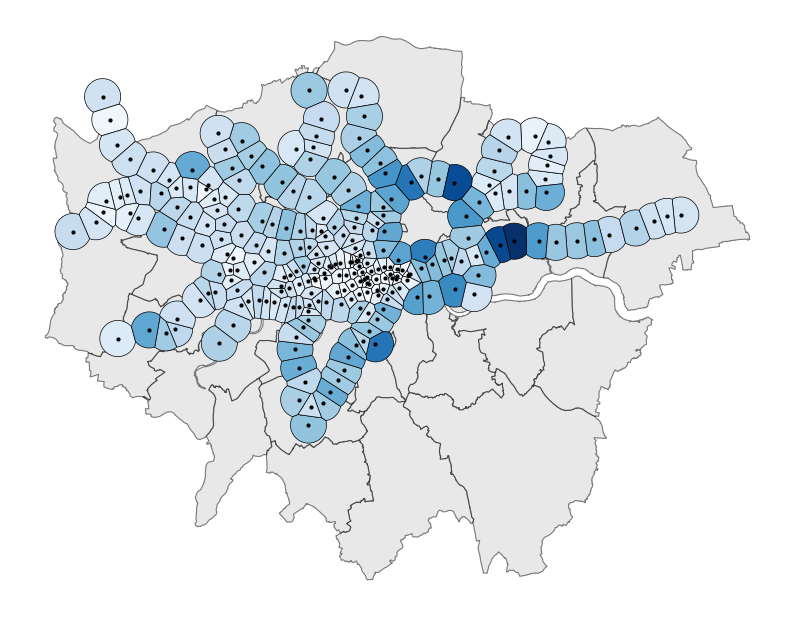

In [55]:
# Extract boroughs from london_gdf
boroughs_gdf = london_gdf[london_gdf["type"] == "borough"].to_crs(voronoi_gdf.crs)

# Plot boroughs as base layer
fig, ax = plt.subplots(figsize=(10, 10))
boroughs_gdf.plot(ax=ax, color="lightgray", edgecolor="black", linewidth=0.8, alpha=0.5, label="Boroughs")

# Overlay Voronoi regions with population-based coloring
voronoi_gdf.plot(ax=ax, color=voronoi_gdf["color"], edgecolor="black", linewidth=0.5, alpha=1, label="Voronoi Cells")

# Overlay subway stations
stations_gdf.plot(ax=ax, color="black", markersize=4, zorder=3)

# Add legend manually

# Adjust plot settings
ax.axis("off")  # Remove axes

plt.show()


In [4]:
# Extract boroughs from london_gdf
boroughs_gdf = london_gdf[london_gdf["type"] == "borough"].to_crs(voronoi_gdf.crs)

# Create figure with transparent background
fig, ax = plt.subplots(figsize=(10, 10), facecolor='none')

# Plot boroughs as base layer
boroughs_gdf.plot(ax=ax, color="lightgray", edgecolor="black", linewidth=0.8, alpha=0.5, label="Boroughs")

# Overlay Voronoi regions with population-based coloring
voronoi_gdf.plot(ax=ax, color=voronoi_gdf["color"], edgecolor="black", linewidth=0.5, alpha=1, label="Voronoi Cells")

# Overlay subway stations
stations_gdf.plot(ax=ax, color="black", markersize=4, zorder=3)

# Remove axes
ax.axis("off")

# Save figure with transparent background
plt.savefig("london_voronoi_map.png", dpi=300, bbox_inches='tight', transparent=True)
plt.close()


In [30]:
print("Voronoi CRS:", voronoi_gdf.crs)
print("Raster CRS:", raster_crs)
print("Stations CRS:", stations_gdf.crs)


Voronoi CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Raster CRS: EPSG:4326
Stations CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


In [31]:

stations_gdf.loc[stations_gdf["name"] == "Bank", "name"] = "Bank & Monument"

# Ensure both GeoDataFrames are in the same CRS
stations_gdf = stations_gdf.to_crs(voronoi_gdf.crs)

# Spatial join: assigning station names to the Voronoi polygons
voronoi_gdf = gpd.sjoin(voronoi_gdf, stations_gdf[['name', 'geometry']], how="left", predicate="contains")

# Create a dictionary for quick lookup of boroughs based on station name index
station_to_borough = {station_list[i]: station_borough_list[i] for i in range(len(station_list))}

In [24]:
voronoi_gdf

,name_left,geometry,population,color,index_right,name_right
0,Acton Town,"POLYGON ((-0.26275 51.50506, -0.27556 51.49786...",18490.091794,#fedb7a,33,Acton Town
1,Aldgate,"POLYGON ((-0.07658 51.51784, -0.07232 51.51196...",1011.378833,#fffec9,34,Aldgate
2,Aldgate East,"POLYGON ((-0.0721 51.52424, -0.05867 51.50849,...",15157.100159,#fee288,35,Aldgate East
3,Alperton,"POLYGON ((-0.28608 51.53796, -0.30818 51.53292...",16399.696430,#fedf83,36,Alperton
4,Angel,"POLYGON ((-0.11278 51.52642, -0.11734 51.53864...",33704.889630,#fd9e43,37,Angel
...,...,...,...,...,...,...
246,Wimbledon,"POLYGON ((-0.20758 51.40998, -0.21394 51.40843...",25863.591301,#febe59,279,Wimbledon
247,Wimbledon Park,"POLYGON ((-0.17964 51.43761, -0.18566 51.42809...",20996.665402,#fed16e,280,Wimbledon Park
248,Wood Green,"POLYGON ((-0.12391 51.58738, -0.12522 51.58817...",31771.494801,#fea647,281,Wood Green
249,Woodford,"POLYGON ((0.05554 51.60554, 0.05554 51.60554, ...",22899.758139,#feca66,282,Woodford


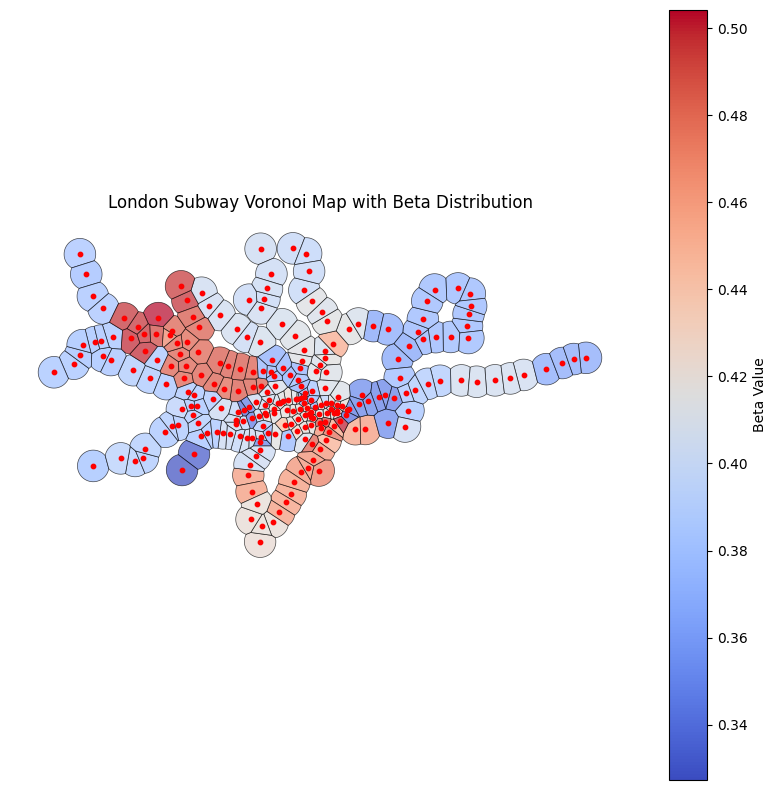

In [25]:
# Ensure the Voronoi regions correspond correctly to station beta values
voronoi_gdf["beta"] = voronoi_gdf["name_right"].map(beta_dict).fillna(0)  # Default to 0 if missing

# Normalize beta values for colormap
beta_values = voronoi_gdf["beta"]
vmin, vmax = beta_values.min(), beta_values.max()

if vmin == vmax:  
    vmin, vmax = 0, 1  # Prevent divide-by-zero issues

norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.get_cmap("coolwarm")  # Adjust colormap as needed
voronoi_gdf["color"] = [mcolors.to_hex(cmap(norm(val))) for val in beta_values]

# Plot the Voronoi diagram with beta-based coloring
fig, ax = plt.subplots(figsize=(10, 10))

# Plot Voronoi regions
voronoi_gdf.plot(ax=ax, color=voronoi_gdf["color"], edgecolor="black", linewidth=0.5, alpha=0.7)

# Plot subway stations
stations_gdf.plot(ax=ax, color="red", markersize=10, label="Subway Stations", zorder=3)

# Add colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Beta Value")

ax.set_title("London Subway Voronoi Map with Beta Distribution")
ax.axis("off")

plt.show()

In [43]:
borough_gdf

,name,type,station1,station2,geometry,total_population
0,Kingston upon Thames,borough,None,None,"POLYGON ((-0.33068 51.32901, -0.33059 51.32909...",163881.552668
1,Croydon,borough,None,None,"POLYGON ((-0.06402 51.31864, -0.06408 51.31861...",374633.669947
2,Bromley,borough,None,None,"POLYGON ((0.01213 51.2996, 0.01196 51.2998, 0....",312910.964745
3,Hounslow,borough,None,None,"POLYGON ((-0.24456 51.4887, -0.24468 51.48868,...",270889.106988
4,Ealing,borough,None,None,"POLYGON ((-0.41183 51.53408, -0.41188 51.53412...",353783.897379
5,Havering,borough,None,None,"POLYGON ((0.15869 51.51219, 0.15871 51.51224, ...",241185.430645
6,Hillingdon,borough,None,None,"POLYGON ((-0.40407 51.61318, -0.40388 51.61229...",285768.637958
7,Harrow,borough,None,None,"POLYGON ((-0.40407 51.61318, -0.4032 51.61318,...",252815.671174
8,Brent,borough,None,None,"POLYGON ((-0.19657 51.52765, -0.19685 51.52773...",331291.112359
9,Barnet,borough,None,None,"POLYGON ((-0.1999 51.67017, -0.1997 51.66986, ...",372974.917987


In [27]:
voronoi_gdf = voronoi_gdf.sort_values(by="name_right").reset_index(drop=True)

voronoi_gdf.head(15)

,name_left,geometry,population,color,index_right,name_right,beta
0,Acton Town,"POLYGON ((-0.26275 51.50506, -0.27556 51.49786...",18490.091794,#a9c6fd,33,Acton Town,0.385679
1,Aldgate,"POLYGON ((-0.07658 51.51784, -0.07232 51.51196...",1011.378833,#e0dbd8,34,Aldgate,0.418066
2,Aldgate East,"POLYGON ((-0.0721 51.52424, -0.05867 51.50849,...",15157.100159,#5572df,35,Aldgate East,0.342853
3,Alperton,"POLYGON ((-0.28608 51.53796, -0.30818 51.53292...",16399.696430,#da5a49,36,Alperton,0.483806
4,Angel,"POLYGON ((-0.11278 51.52642, -0.11734 51.53864...",33704.889630,#d4dbe6,37,Angel,0.410041
5,Archway,"POLYGON ((-0.12078 51.56136, -0.1235 51.55951,...",37748.741714,#dadce0,38,Archway,0.413977
6,Arnos Grove,"POLYGON ((-0.1455 51.6047, -0.14551 51.60472, ...",25377.717524,#bfd3f6,39,Arnos Grove,0.397093
7,Arsenal,"POLYGON ((-0.10311 51.5526, -0.12023 51.56123,...",27886.267070,#dedcdb,40,Arsenal,0.416563
8,Baker Street,"POLYGON ((-0.15388 51.51827, -0.15902 51.51864...",7359.429193,#e4d9d2,41,Baker Street,0.420927
9,Balham,"POLYGON ((-0.17376 51.44606, -0.17374 51.44614...",28629.201101,#f4987a,42,Balham,0.460253


NameError: name 'pop_vector' is not defined

In [14]:
for i in range(251):
    if list(voronoi_gdf["name"])[i] != station_list[i]:
        print("bad",i)

In [11]:
# Standardized borough name mapping (fix inconsistencies)
borough_name_mapping = {
    "Barking & Dagenham": "Barking and Dagenham",
    "Hammersmith & Fulham": "Hammersmith and Fulham",
    "Kensington & Chelsea": "Kensington and Chelsea",
    "City of Westminster": "Westminster",  # If needed
    "Hackney": "Westminster/Hackney/City of London",
    "City of London": "Westminster/Hackney/City of London",
    "Westminster,City of London": "Westminster/Hackney/City of London"
}

# Standardize borough names in borough_gdf
borough_gdf["name"] = borough_gdf["name"].replace(borough_name_mapping)

# Recalculate population sum after merging renamed boroughs
borough_population_dict = borough_gdf.groupby("name")["total_population"].sum().to_dict()

# Standardize borough names in voronoi_gdf before merging
voronoi_gdf["Borough"] = voronoi_gdf["Borough"].replace(borough_name_mapping)

# Identify missing borough assignments after renaming
missing_boroughs = voronoi_gdf[voronoi_gdf["Borough"].isna()]
if not missing_boroughs.empty:
    print("Warning: The following Voronoi regions have no assigned boroughs after renaming:")
    print(missing_boroughs[["name", "population"]])

# Compute borough proportions with standardized names
voronoi_gdf["borough_proportion"] = voronoi_gdf.apply(
    lambda row: row["population"] / borough_population_dict[row["Borough"]]
    if row["Borough"] in borough_population_dict and borough_population_dict[row["Borough"]] > 0 else np.nan, axis=1
)

# Identify rows where borough_proportion is NaN
nan_proportion_rows = voronoi_gdf[voronoi_gdf["borough_proportion"].isna()]
if not nan_proportion_rows.empty:
    print("Warning: The following rows have NaN borough_proportion due to missing population data:")
    print(nan_proportion_rows[["name", "Borough", "population"]])


NameError: name 'borough_gdf' is not defined

In [46]:
voronoi_gdf

,FID,geometry,population,color,index_right,name,beta,Borough,borough_proportion
0,0,"POLYGON ((0.241 51.57057, 0.24101 51.57057, 0....",13799.586823,#7da0f9,251,Upminster,0.530383,Havering,0.057216
1,1,"POLYGON ((0.22021 51.5678, 0.22021 51.5678, 0....",12517.177515,#7da0f9,252,Upminster Bridge,0.530260,Havering,0.051899
2,2,"POLYGON ((-0.45726 51.5411, -0.4573 51.54103, ...",18610.252733,#799cf8,255,Uxbridge,0.529559,Hillingdon,0.065123
3,3,"POLYGON ((0.1617 51.53097, 0.1617 51.53097, 0....",31846.449716,#7699f6,85,Dagenham Heathway,0.529036,Barking and Dagenham,0.164674
4,4,"POLYGON ((-0.40213 51.46438, -0.40214 51.46438...",9922.499465,#7093f3,126,Hatton Cross,0.527910,Hillingdon,0.034722
...,...,...,...,...,...,...,...,...,...
246,246,"POLYGON ((-0.09467 51.50657, -0.09744 51.50657...",736.449160,#81a4fb,163,Mansion House,0.531233,Westminster/Hackney/City of London,0.001467
247,247,"POLYGON ((-0.0838 51.50909, -0.09424 51.50651,...",184.264177,#81a4fb,69,Cannon Street,0.531225,Westminster/Hackney/City of London,0.000367
248,248,"POLYGON ((-0.08631 51.5159, -0.08446 51.52172,...",2480.245025,#82a6fb,159,Liverpool Street,0.531418,Westminster/Hackney/City of London,0.004942
249,249,"POLYGON ((-0.07232 51.51196, -0.06011 51.50821...",5452.406632,#6e90f2,247,Tower Hill,0.527232,Tower Hamlets,0.019641


In [47]:
lambeth_stations = voronoi_gdf[voronoi_gdf["Borough"] == "Lambeth"]
lambeth_stations['borough_proportion']

190    0.070035
191    0.176542
192    0.101993
204    0.095329
205    0.091252
207    0.036846
208    0.024378
210    0.007462
Name: borough_proportion, dtype: float64

In [70]:
station_dict

{'Grange Hill': ['Redbridge', 0.05145162054435694],
 'Uxbridge': ['Hillingdon', 0.13128248682286525],
 'Croxley': ['Hillingdon', 0.10346324733896071],
 'Northwood': ['Hillingdon', 0.07639409625963299],
 'Elm Park': ['Havering', 0.3709258816923307],
 'Hounslow West': ['Hounslow', 0.28445003947783726],
 'Hatton Cross': ['Hillingdon', 0.11388924126428114],
 'Hillingdon': ['Hillingdon', 0.08621427363432568],
 'Ruislip': ['Hillingdon', 0.04505372994591769],
 'Ickenham': ['Hillingdon', 0.02906396081012109],
 'West Ruislip': ['Hillingdon', 0.05200723562042184],
 'Moor Park': ['Hillingdon', 0.02306621859067798],
 'Upminster Bridge': ['Havering', 0.17466303006529027],
 'Upminster': ['Havering', 0.23148298341754436],
 'Hornchurch': ['Havering', 0.22292810482483472],
 'Hainault': ['Redbridge', 0.0510210601734557],
 'Northolt': ['Ealing', 0.13533281733986058],
 'Wimbledon': ['Merton', 0.21121754901619788],
 'East Putney': ['Wandsworth', 0.1709128842859445],
 'Eastcote': ['Hillingdon', 0.0848159579

In [62]:
# Create a dictionary with station names as keys and [borough, borough_proportion] as values
station_dict = voronoi_gdf.set_index("name")[["Borough", "borough_proportion"]].to_dict(orient="index")

# Define borough name replacements
borough_replacements = {
    "Westminster,City of London": "Westminster/Hackney/City of London",
    "Hackney": "Westminster/Hackney/City of London",
    "Barking and Dagenham": "Barking & Dagenham",
    "Hammersmith and Fulham": "Hammersmith & Fulham",
    "Kensington and Chelsea": "Kensington & Chelsea",
}

# Convert dictionary values to lists and rename boroughs if necessary
station_dict = {
    key: [
        borough_replacements.get(value["Borough"], value["Borough"]),  # Replace borough name if in dictionary
        value["borough_proportion"]
    ]
    for key, value in station_dict.items()
}


In [63]:
station_dict

{'Upminster': ['Havering', 0.05721567337471675],
 'Upminster Bridge': ['Havering', 0.051898564027551705],
 'Uxbridge': ['Hillingdon', 0.06512349593844856],
 'Dagenham Heathway': ['Barking & Dagenham', 0.16467350601436553],
 'Hatton Cross': ['Hillingdon', 0.034722142836143874],
 'Hounslow West': ['Hounslow', 0.14966430229313865],
 'Northwood': ['Hillingdon', 0.04708478784890986],
 'Eastcote': ['Hillingdon', 0.0553458383164586],
 'South Ruislip': ['Hillingdon', 0.043591377617583145],
 'Hillingdon': ['Hillingdon', 0.04715274349190353],
 'Grange Hill': ['Redbridge', 0.03510676351842543],
 'Hornchurch': ['Havering', 0.06205103084224812],
 'Elm Park': ['Havering', 0.09857533052926344],
 'Hounslow East': ['Hounslow', 0.07637739820670635],
 'Richmond': ['Richmond upon Thames', 0.13113838202233308],
 'Osterley': ['Hounslow', 0.059243701515676275],
 'Hounslow Central': ['Hounslow', 0.10354181587951888],
 'East Putney': ['Wandsworth', 0.1080990717779436],
 'Fulham Broadway': ['Hammersmith & Fulha

In [64]:
# with open("Proper London Station Borough Proportions Dict.pkl", "wb") as f:
    # pickle.dump(station_dict, f)

In [23]:
station_borough_list

array(['Ealing', 'Westminster,City of London', 'Tower Hamlets', 'Brent',
       'Islington', 'Islington', 'Enfield', 'Islington',
       'Westminster,City of London', 'Wandsworth',
       'Westminster,City of London', 'Westminster,City of London',
       'Barking & Dagenham', 'Redbridge', 'Hammersmith & Fulham',
       'Westminster,City of London', 'Barking & Dagenham', 'Camden',
       'Southwark', 'Tower Hamlets', 'Westminster,City of London',
       'Waltham Forest', 'Westminster,City of London', 'Southwark',
       'Ealing', 'Haringey', 'Tower Hamlets', 'Barnet', 'Lambeth',
       'Tower Hamlets', 'Barnet', 'Islington', 'Camden', 'Southwark',
       'Tower Hamlets', 'Newham', 'Westminster,City of London', 'Harrow',
       'Camden', 'Westminster,City of London',
       'Westminster,City of London', 'Redbridge', 'Ealing', 'Lambeth',
       'Lambeth', 'Wandsworth', 'Enfield', 'Barnet', 'Merton',
       'Westminster,City of London', 'Hillingdon', 'Barking & Dagenham',
       'Barking &

In [51]:
# Get all assigned station names
assigned_stations = set(voronoi_gdf["name"].dropna())

# Find missing stations
missing_stations = stations_gdf[~stations_gdf["name"].isin(assigned_stations)]
print(missing_stations[["name", "geometry"]])
print(f"Number of missing stations: {len(missing_stations)}")


Empty GeoDataFrame
Columns: [name, geometry]
Index: []
Number of missing stations: 0


In [24]:
voronoi_gdf

,FID,geometry,population,color,index_right,name
0,0,"POLYGON ((0.09444 51.63015, 0.09491 51.63013, ...",12992.440495,#ffea9b,114,Grange Hill
1,1,"POLYGON ((-0.45456 51.53728, -0.45469 51.53714...",24482.665199,#fed470,255,Uxbridge
2,2,"POLYGON ((-0.45497 51.66151, -0.45431 51.66175...",19294.698831,#fee084,83,Croxley
3,3,"POLYGON ((-0.43513 51.59602, -0.43514 51.59604...",14246.615273,#ffe997,182,Northwood
4,4,"POLYGON ((0.21688 51.53766, 0.21687 51.53766, ...",29807.041185,#fec15d,99,Elm Park
...,...,...,...,...,...,...
246,246,"POLYGON ((-0.19732 51.51536, -0.19548 51.51479...",11303.059914,#ffeda1,184,Notting Hill Gate
247,247,"POLYGON ((-0.20371 51.51283, -0.19895 51.50404...",8718.166560,#fff1ab,134,Holland Park
248,248,"POLYGON ((-0.21191 51.52662, -0.1981 51.52819,...",26789.214582,#fecc68,273,Westbourne Park
249,249,"POLYGON ((-0.20968 51.512, -0.21437 51.50909, ...",10782.802354,#ffefa4,155,Latimer Road


In [52]:
import pickle

# Save Voronoi GeoDataFrame to a pickle file
# with open("Proper London_Patch_Population_Map_1_5km.pkl", "wb") as f:
    # pickle.dump(voronoi_gdf, f)

In [54]:
voronoi_gdf

,FID,geometry,population,color,index_right,name,beta,Borough,borough_proportion
0,0,"POLYGON ((0.241 51.57057, 0.24101 51.57057, 0....",13799.586823,#7da0f9,251,Upminster,0.530383,Havering,0.057216
1,1,"POLYGON ((0.22021 51.5678, 0.22021 51.5678, 0....",12517.177515,#7da0f9,252,Upminster Bridge,0.530260,Havering,0.051899
2,2,"POLYGON ((-0.45726 51.5411, -0.4573 51.54103, ...",18610.252733,#799cf8,255,Uxbridge,0.529559,Hillingdon,0.065123
3,3,"POLYGON ((0.1617 51.53097, 0.1617 51.53097, 0....",31846.449716,#7699f6,85,Dagenham Heathway,0.529036,Barking and Dagenham,0.164674
4,4,"POLYGON ((-0.40213 51.46438, -0.40214 51.46438...",9922.499465,#7093f3,126,Hatton Cross,0.527910,Hillingdon,0.034722
...,...,...,...,...,...,...,...,...,...
246,246,"POLYGON ((-0.09467 51.50657, -0.09744 51.50657...",736.449160,#81a4fb,163,Mansion House,0.531233,Westminster/Hackney/City of London,0.001467
247,247,"POLYGON ((-0.0838 51.50909, -0.09424 51.50651,...",184.264177,#81a4fb,69,Cannon Street,0.531225,Westminster/Hackney/City of London,0.000367
248,248,"POLYGON ((-0.08631 51.5159, -0.08446 51.52172,...",2480.245025,#82a6fb,159,Liverpool Street,0.531418,Westminster/Hackney/City of London,0.004942
249,249,"POLYGON ((-0.07232 51.51196, -0.06011 51.50821...",5452.406632,#6e90f2,247,Tower Hill,0.527232,Tower Hamlets,0.019641


In [33]:
# Create a structured NumPy array for station names and populations
station_population_array = np.array(
    list(zip(voronoi_gdf["name_right"], voronoi_gdf["population"])),
    dtype=[("Station", "U50"), ("Population", "f8")]
)

# Convert to a dictionary
station_population_dict = {row["Station"]: row["Population"] for row in station_population_array}

# Sort the dictionary by population in descending order
sorted_station_population_dict = dict(sorted(station_population_dict.items(), key=lambda item: item[0], reverse=False))

# Print the unsorted dictionary
print("\nUnsorted Station Population Dictionary:")
print(station_population_dict)

# Print the sorted dictionary
print("\nSorted Station Population Dictionary (Highest to Lowest):")
print(sorted_station_population_dict)



Unsorted Station Population Dictionary:
{np.str_('Acton Town'): np.float64(18490.091793896856), np.str_('Aldgate'): np.float64(1011.3788329847816), np.str_('Aldgate East'): np.float64(15157.100159294238), np.str_('Alperton'): np.float64(16399.696430101812), np.str_('Angel'): np.float64(33704.88962954088), np.str_('Archway'): np.float64(37748.741714017895), np.str_('Arnos Grove'): np.float64(25377.71752354757), np.str_('Arsenal'): np.float64(27886.267069930553), np.str_('Baker Street'): np.float64(7359.429192628172), np.str_('Balham'): np.float64(28629.201101307593), np.str_('Bank & Monument'): np.float64(126.98899842593559), np.str_('Barbican'): np.float64(7853.374970710645), np.str_('Barking'): np.float64(44523.37998992976), np.str_('Barkingside'): np.float64(11491.299653120468), np.str_('Barons Court'): np.float64(18506.14328997732), np.str_('Bayswater'): np.float64(7658.57500182733), np.str_('Becontree'): np.float64(29356.1341605052), np.str_('Belsize Park'): np.float64(23387.12490

In [34]:
# with open("Proper_London_Patch_Populations_1_5km_fixed.pkl", "wb") as f:
    # pickle.dump(sorted_station_population_dict, f)

In [19]:
voronoi_gdf

,FID,geometry,population,color,index_right,name,beta
0,114,"POLYGON ((-0.26275 51.50506, -0.27556 51.49786...",18490.091794,#a9c6fd,33,Acton Town,0.385679
1,250,"POLYGON ((-0.07658 51.51784, -0.07232 51.51196...",1011.378833,#e0dbd8,34,Aldgate,0.418066
2,209,"POLYGON ((-0.0721 51.52424, -0.05867 51.50849,...",15157.100159,#5572df,35,Aldgate East,0.342853
3,182,"POLYGON ((-0.28608 51.53796, -0.30818 51.53292...",16399.696430,#da5a49,36,Alperton,0.483806
4,231,"POLYGON ((-0.11278 51.52642, -0.11734 51.53864...",33704.889630,#d4dbe6,37,Angel,0.410041
...,...,...,...,...,...,...,...
246,101,"POLYGON ((-0.20758 51.40998, -0.21394 51.40843...",25863.591301,#e5d8d1,279,Wimbledon,0.421910
247,97,"POLYGON ((-0.17964 51.43761, -0.18566 51.42809...",20996.665402,#e4d9d2,280,Wimbledon Park,0.421008
248,73,"POLYGON ((-0.12391 51.58738, -0.12522 51.58817...",31771.494801,#d4dbe6,281,Wood Green,0.409807
249,88,"POLYGON ((0.05554 51.60554, 0.05554 51.60554, ...",22899.758139,#90b2fe,282,Woodford,0.373072
